In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import time
import sklearn
from tabulate import tabulate
import networkx as nx
import nxviz as nv
# for Notebook
from tqdm import tqdm
import numpy as np
import statsmodels.api as sm
import pylab
import numpy as np
from scipy import stats

%matplotlib inline

/home/gh8sj/.local/lib/python3.11/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [4]:
# load data
X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/lasso_selected_q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)


In [5]:
# re generate lasso
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

from scipy.stats import zscore 

y_str = X['survival group']
X = X.drop(columns=['survival group'])
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
X = X.fillna(0)
X = stats.zscore(X, ddof = 1)


#z_score_x = zscore(X.astype(float), axis = 1, ddof=1)

# parameters to be tested on GridSearchCV


# Number of Folds and adding the random state for replication

# Initializing the Model
lassocv = LassoCV(alphas=[1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1],cv = 10)


# GridSearchCV with model, params and folds.
lassocv.fit(X,y)
lasso_feat = lassocv.coef_
selected_features = np.array(X.columns)[lasso_feat != 0]
lasso_selected_x = X.loc[:,X.columns.isin(selected_features)]


100%|██████████| 1000/1000 [00:04<00:00, 244.37it/s]


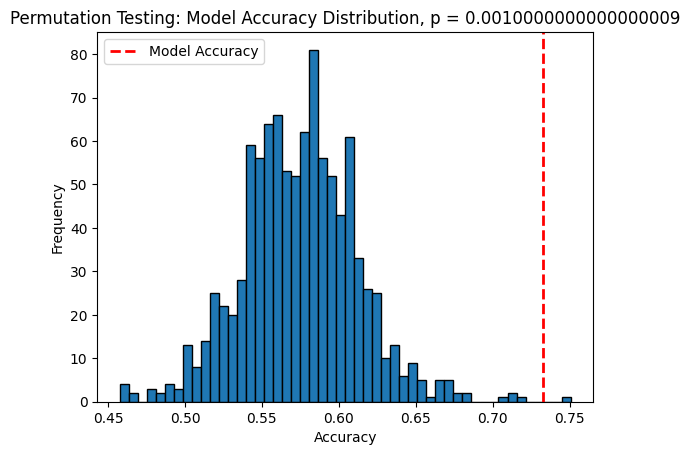

In [6]:
# re run plsda 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import bisect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score, accuracy_score


def count_values_greater_than(sorted_list, target_value):
    # Use bisect_right to find the index of the first element greater than the target_value
    index = bisect.bisect_right(sorted_list, target_value)
    
    # The count of values greater than the target_value is the length of the list minus the index
    count = len(sorted_list) - index
    
    return count

def round_to_sign(value):
    if value >= 0:
        return np.ceil(value)
    else:
        return np.floor(value)


X = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/lasso_selected_q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)
y_str = X['survival group']
X = X.drop(columns=['survival group'])
X = X.loc[:,X.columns.isin(selected_features)]
X = stats.zscore(X, ddof = 0)
y = y_str.apply(lambda x: 1 if x == '> 3 years' else -1)
y





# do you orthogoranlize all the permutations? -> yes



# Generate some example data
np.random.seed(42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
opls = OPLS(2) # 1 components
Z = opls.fit_transform(X, y)
pls_model = PLSRegression(2)


pls_model.fit(Z, y)
#y_pred= pls.predict(X)
processed_y_pred = cross_val_predict(pls_model, Z, y, cv=5)

                           
processed_q_squared = r2_score(y, processed_y_pred) 
processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
processed_accuracy_rounded = round(processed_accuracy,2)

variance_in_x = np.var(pls_model.x_scores_, axis = 0) 
total_variance_in_x = np.var(Z, axis = 0)
# normalize variance by total variance:
#fractions_of_explained_variance = variance_in_x / total_variance_in_x

r2_X = opls.score(X)  # 7.8e-12 (most variance is removed)


# Number of permutations
num_permutations = 1000

# List to store permutation accuracies
permuted_accuracies = []

# Permutation testing loop
for _ in tqdm(range(num_permutations)):
    # Randomly permute the labels
    permuted_labels = np.random.permutation(y)
    
    
#processed_y_pred = cross_val_predict(pls, Z, y, cv=1000)
#processed_q_squared = r2_score(y, processed_y_pred)  # 0.981
#processed_dq_squared = r2_score(y, np.clip(processed_y_pred, -1, 1))  # 0.984
#processed_accuracy = accuracy_score(y, np.sign(processed_y_pred))  # 1.0
    opls = OPLS(2) # 1 components
    Z_i = opls.fit_transform(X, permuted_labels)

    #permuted_model.fit(X, permuted_labels)
    pls = PLSRegression(1)
    permuted_pred = cross_val_predict(pls, Z_i, permuted_labels, cv=5) # I should change this to something smaller, leave one out would literally take foever
    # Make predictions with the permuted model
    #permuted_predictions = permuted_model.predict(X)
    
    # Calculate accuracy and store in the list
    permuted_pred = [round_to_sign(value) for value in permuted_pred]# Round each value in the list based on the specified rules


    permuted_accuracy = accuracy_score(y, permuted_pred)
    permuted_accuracies.append(permuted_accuracy)

    
permuted_accuracies = pd.Series(np.sort(permuted_accuracies), index = range(1000))
result_count = count_values_greater_than(permuted_accuracies, processed_accuracy)
p = 1-(1000-result_count)/1000
p_round = round(p,3)

# Plotting the histogram
plt.hist(permuted_accuracies, bins=50, edgecolor='black')
plt.axvline(x=processed_accuracy, color='red', linestyle='dashed', linewidth=2, label='Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Permutation Testing: Model Accuracy Distribution, p = {p}')
plt.legend()
plt.show()

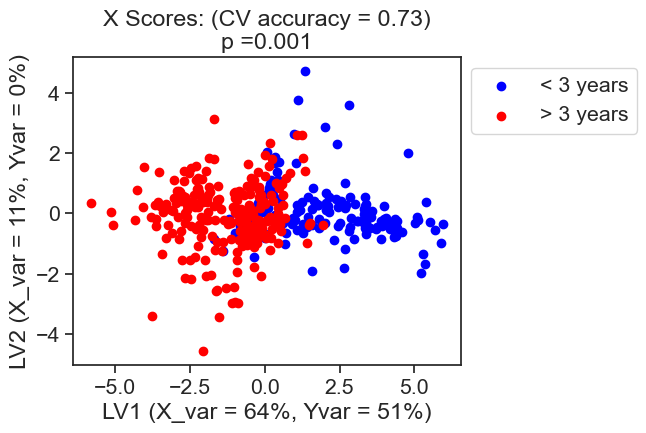

In [7]:
# scores plot 
#plt.figure(1)
#df = pd.DataFrame(np.column_stack([pls_model.x_scores_, opls.T_ortho_[:, 0]]),
#                  index=y.index, columns=['t', 't_ortho'])
import matplotlib.colors as colors
sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(5, 4)) 

df = pd.DataFrame(np.column_stack([pls_model.x_scores_]),
                  index=y.index, columns=['lv1', 'lv2'])       
pos_df = df[y==1]
neg_df = df[y==-1]
plt.scatter(neg_df['lv1'], neg_df['lv2'], c='blue', label='< 3 years')
plt.scatter(pos_df['lv1'], pos_df['lv2'], c='red', label='> 3 years')
plt.title(f'X Scores: (CV accuracy = {processed_accuracy_rounded})\np ={p_round}')
plt.xlabel('LV1 (X_var = 64%, Yvar = 51%)')
plt.ylabel('LV2 (X_var = 11%, Yvar = 0%)')
plt.legend(bbox_to_anchor = (1,1))
#plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7c_scores.pdf',format='pdf', bbox_inches = 'tight')
plt.show()

Text(0.5, 1.0, 'VIPs for oPLSDA model')

<Figure size 400x600 with 0 Axes>

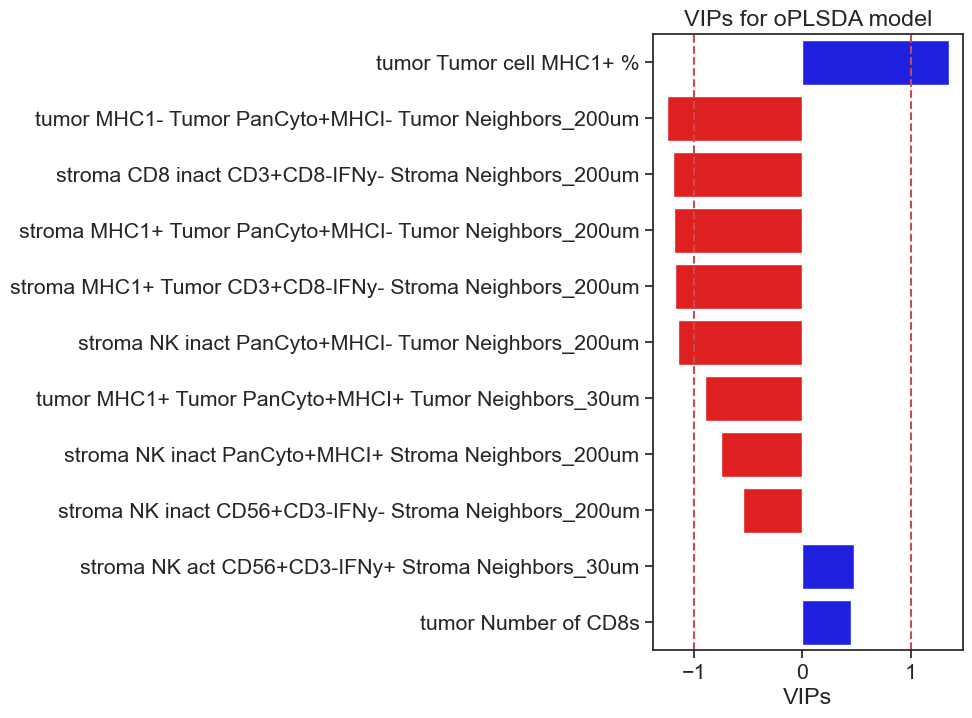

In [8]:

# lets try to make a VIP score with the same logic as Rem's code:
# Calculate VIP scores
def vip_efficient(model):
    t = model.x_scores_
    w = model.x_weights_ # replace with x_rotations_ if needed
    q = model.y_loadings_ 
    features_, _ = w.shape
    vip = np.zeros(shape=(features_,))
    inner_sum = np.diag(t.T @ t @ q.T @ q)
    SS_total = np.sum(inner_sum)
    vip = np.sqrt(features_*(w**2 @ inner_sum)/ SS_total)
    return vip

vips = vip_efficient(pls_model)

sns.set(font_scale = 1.4)
sns.set_style("ticks")
plt.figure(figsize=(4, 6)) 
plt.figure(figsize=(4, 8)) 


loadings_vips = pd.DataFrame(pls_model.x_loadings_[:,0].flatten(), index= X.columns, columns = ['loadings'])
loadings_vips['VIPs'] = vips
loadings_vips['color'] = np.where(loadings_vips['loadings'] > 0, '> 3 years', '< 3 years')
colors = {'< 3 years': 'red', '> 3 years': 'blue'}

loadings_vips = loadings_vips.sort_values(by = 'VIPs', ascending=False)
for i in loadings_vips.index:
    if loadings_vips.loc[i,'loadings'] < 0:
        loadings_vips.loc[i,'VIPs'] = loadings_vips.loc[i,'VIPs']*-1
sns.barplot(data = loadings_vips, x=loadings_vips['VIPs'],y = loadings_vips.index, hue = 'color', palette = colors)
plt.axvline(x = -1, color = 'r', linestyle='--')
plt.axvline(x = 1, color = 'r', linestyle='--')
plt.legend().set_visible(False)
plt.ylabel('')
plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7d_VIPS.pdf',format='pdf', bbox_inches = 'tight')
plt.title('VIPs for oPLSDA model')

In [9]:
loadings_vips['label'] = loadings_vips['color']
loadings_vips['color'] = np.where(loadings_vips['loadings'] > 0, 'blue', 'red')

In [10]:
# select lasso selected features and add them to dcitionary
lasso_X = X 
dfs_vips = list(lasso_X.columns)
color_dict = {}

# Iterate over the DataFrame rows
for index, row in loadings_vips.iterrows():
    color = row['color']
    color_dict[index] = color

print(color_dict)

{'tumor Tumor cell MHC1+ %': 'blue', 'tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbors_200um': 'red', 'stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_200um': 'red', 'stroma MHC1+ Tumor PanCyto+MHCI- Tumor Neighbors_200um': 'red', 'stroma MHC1+ Tumor CD3+CD8-IFNy- Stroma Neighbors_200um': 'red', 'stroma NK inact PanCyto+MHCI- Tumor Neighbors_200um': 'red', 'tumor MHC1+ Tumor PanCyto+MHCI+ Tumor Neighbors_30um': 'red', 'stroma NK inact PanCyto+MHCI+ Stroma Neighbors_200um': 'red', 'stroma NK inact CD56+CD3-IFNy- Stroma Neighbors_200um': 'red', 'stroma NK act CD56+CD3-IFNy+ Stroma Neighbors_30um': 'blue', 'tumor Number of CD8s': 'blue'}


In [11]:
lasso_X.columns[:-1]

Index(['tumor Number of CD8s', 'tumor Tumor cell MHC1+ %',
       'tumor MHC1+ Tumor PanCyto+MHCI+ Tumor Neighbors_30um',
       'tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbors_200um',
       'stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbors_200um',
       'stroma NK act CD56+CD3-IFNy+ Stroma Neighbors_30um',
       'stroma NK inact CD56+CD3-IFNy- Stroma Neighbors_200um',
       'stroma NK inact PanCyto+MHCI+ Stroma Neighbors_200um',
       'stroma NK inact PanCyto+MHCI- Tumor Neighbors_200um',
       'stroma MHC1+ Tumor CD3+CD8-IFNy- Stroma Neighbors_200um'],
      dtype='object')

In [12]:
# designate loadings that are significant
sig_loads = loadings_vips.loc[np.abs(loadings_vips['VIPs']) >1]

In [13]:
# read in og dataset
df = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act.csv',index_col=0)


In [14]:
X = df.drop(['patient', 'survival group'],axis = 1)

# first do a correlation heatmap

In [15]:
corr = X.corr()
corr.columns.name = ''

In [16]:
corr;

In [17]:
# takes a while to run this
def correlation_p_value(x, y):
    _, p_value = stats.pearsonr(x, y)
    return p_value

# Create a DataFrame to hold the p-values
p_values = pd.DataFrame(np.zeros((len(corr), len(corr))), 
                        index=corr.columns, 
                        columns=corr.columns)

for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2:
            p_values.loc[col1, col2] = correlation_p_value(df[col1], df[col2])

In [18]:
rows = []

for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2:
            r = corr.loc[col1, col2]
            p = p_values.loc[col1, col2]
            r2 = r ** 2
            rows.append([col1, col2, r, p, r2])
        elif col1 == col2:
            r = corr.loc[col1, col2]
            p = p_values.loc[col1, col2]
            r2 = r ** 2
            rows.append([col1, col2, r, p, r2])

# Create the final DataFrame
correlation_df = pd.DataFrame(rows, columns=['Source', 'Target', 'Correlation', 'P-Value', 'R^2'])

In [19]:
correlation_df ;

In [20]:
subset_corr_df = correlation_df[correlation_df['Source'].isin(color_dict.keys())]

#subset_corr_df.to_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act_for_subset_cytoscape.csv', sep='\t')


In [21]:
subset_corr_df[(abs(subset_corr_df['Correlation']) > .75) & (subset_corr_df.Source.isin(list(loadings_vips[abs(loadings_vips['VIPs']) >= 0.99].index)))]

,Source,Target,Correlation,P-Value,R^2
3174,tumor Tumor cell MHC1+ %,tumor Tumor cell MHC1+ %,1.000000,0.000000e+00,1.000000
138406,tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbor...,tumor CD8 inact PanCyto+MHCI- Tumor Neighbors_...,0.821377,2.137207e-96,0.674661
138566,tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbor...,tumor MHC1+ Tumor PanCyto+MHCI- Tumor Neighbor...,0.885201,1.097268e-130,0.783580
138590,tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbor...,tumor MHC1- Tumor CD3+CD8-IFNy- Tumor Neighbor...,0.751288,7.731878e-72,0.564433
138598,tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbor...,tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbor...,1.000000,0.000000e+00,1.000000
138670,tumor MHC1- Tumor PanCyto+MHCI- Tumor Neighbor...,stroma CD8 inact PanCyto+MHCI- Tumor Neighbors...,0.779839,9.638732e-81,0.608149
172715,stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbor...,tumor CD8 inact CD3+CD8+IFNy- Stroma Neighbors...,0.750068,1.743654e-71,0.562602
172719,stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbor...,tumor CD8 inact CD3+CD8-IFNy- Stroma Neighbors...,0.846118,8.358545e-108,0.715915
172875,stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbor...,tumor MHC1+ Tumor CD3+CD8+IFNy- Stroma Neighbo...,0.751861,5.267575e-72,0.565294
172879,stroma CD8 inact CD3+CD8-IFNy- Stroma Neighbor...,tumor MHC1+ Tumor CD3+CD8-IFNy- Stroma Neighbo...,0.839551,1.372720e-104,0.704846


# 0.75 correlation threshold

In [26]:
subset_corr_df[(abs(subset_corr_df['Correlation']) > .75) & (subset_corr_df.Source.isin(list(loadings_vips[abs(loadings_vips['VIPs']) >= 0.99].index)))].to_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act_for_shortest_subset_cytoscape.csv', sep='\t')


In [27]:
correlation_df.to_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act_for_cytoscape.csv', sep='\t')


In [28]:
subset_corr_df[abs(subset_corr_df['Correlation']) > .7].to_csv('/scratch/gh8sj/brown_nsclc/data/output_data/q3_dfs_target_neighbor_center_cell_act_for_shortest_subset_cytoscape.csv', sep='\t')


In [48]:
import scipy.stats as stats

corr = X.corr(method=lambda x, y: stats.pearsonr(x, y)[0]) 

# this computes the p-values
pvalues = X.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(df.iloc[:,:-2].columns)) 
pvalues

,tumor CD8 IFNg+ %,tumor Number of CD8s,tumor CD3 IFNg+ %,tumor Number of CD3s,tumor NK IFNg+ %,tumor Number of NKs,tumor Tumor cell MHC1+ %,tumor Number of Tumor cells,tumor CD8 act CD3+CD8+IFNy+ Tumor Neighbors_30um,tumor CD8 act CD3+CD8+IFNy+ Stroma Neighbors_30um,...,stroma MHC1- Tumor CD3+CD8-IFNy- Tumor Neighbors_200um,stroma MHC1- Tumor CD3+CD8-IFNy- Stroma Neighbors_200um,stroma MHC1- Tumor CD56+CD3-IFNy+ Tumor Neighbors_200um,stroma MHC1- Tumor CD56+CD3-IFNy+ Stroma Neighbors_200um,stroma MHC1- Tumor CD56+CD3-IFNy- Tumor Neighbors_200um,stroma MHC1- Tumor CD56+CD3-IFNy- Stroma Neighbors_200um,stroma MHC1- Tumor PanCyto+MHCI+ Tumor Neighbors_200um,stroma MHC1- Tumor PanCyto+MHCI+ Stroma Neighbors_200um,stroma MHC1- Tumor PanCyto+MHCI- Tumor Neighbors_200um,stroma MHC1- Tumor PanCyto+MHCI- Stroma Neighbors_200um
,,,,,,,,,,,,,,,,,,,,,
tumor CD8 IFNg+ %,0.000000e+00,8.732070e-01,4.469045e-70,7.584907e-02,1.966250e-23,3.914331e-02,0.062047,1.135939e-02,6.593874e-10,0.002964,...,2.938605e-01,1.022528e-01,5.682699e-02,2.471315e-01,2.816286e-01,3.261787e-01,7.653966e-01,7.530891e-01,1.135488e-01,7.783763e-01
tumor Number of CD8s,8.732070e-01,0.000000e+00,3.920934e-01,5.961717e-42,6.180971e-01,6.824561e-04,0.647006,2.470695e-17,1.704373e-02,0.687439,...,1.633134e-01,9.747353e-01,5.746301e-01,2.819984e-01,3.113091e-01,4.630477e-01,9.297009e-01,8.435143e-01,4.912863e-02,6.047859e-04
tumor CD3 IFNg+ %,4.469045e-70,3.920934e-01,0.000000e+00,2.723623e-01,4.995809e-18,7.148114e-02,0.062580,1.152390e-01,1.896687e-01,0.292179,...,6.475844e-01,1.541643e-01,3.763517e-02,1.731156e-01,5.140985e-01,1.851677e-01,9.603129e-01,5.613241e-01,1.941763e-01,8.801712e-01
tumor Number of CD3s,7.584907e-02,5.961717e-42,2.723623e-01,0.000000e+00,3.098629e-01,6.312923e-31,0.000777,3.760924e-05,1.397315e-01,0.678617,...,5.004980e-02,4.173614e-01,7.638341e-01,9.633485e-01,1.736308e-01,8.675647e-01,9.713799e-01,8.873125e-01,2.840034e-01,5.622901e-03
tumor NK IFNg+ %,1.966250e-23,6.180971e-01,4.995809e-18,3.098629e-01,0.000000e+00,5.536771e-02,0.011246,1.173550e-01,4.233825e-01,0.009079,...,8.260244e-01,9.591863e-01,1.142845e-13,3.234842e-08,1.180456e-01,9.718262e-01,1.022503e-01,3.253225e-01,9.450928e-01,4.824725e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stroma MHC1- Tumor CD56+CD3-IFNy- Stroma Neighbors_200um,3.261787e-01,4.630477e-01,1.851677e-01,8.675647e-01,9.718262e-01,7.226229e-01,0.016096,5.296397e-02,3.750484e-01,0.263789,...,8.003415e-17,1.181519e-21,1.042771e-01,1.448797e-02,1.091434e-25,0.000000e+00,4.195040e-07,3.354961e-12,4.100453e-11,2.330692e-04
stroma MHC1- Tumor PanCyto+MHCI+ Tumor Neighbors_200um,7.653966e-01,9.297009e-01,9.603129e-01,9.713799e-01,1.022503e-01,7.682015e-04,0.349341,9.755501e-01,3.527320e-01,0.575313,...,1.117764e-69,1.172119e-50,2.007732e-04,4.550149e-04,3.532199e-08,4.195040e-07,0.000000e+00,2.259127e-70,3.349632e-60,4.902623e-24
stroma MHC1- Tumor PanCyto+MHCI+ Stroma Neighbors_200um,7.530891e-01,8.435143e-01,5.613241e-01,8.873125e-01,3.253225e-01,6.739185e-03,0.428808,2.393191e-01,2.692613e-01,0.544241,...,5.670671e-53,2.390311e-54,1.339614e-04,5.400561e-04,4.197414e-11,3.354961e-12,2.259127e-70,0.000000e+00,1.009271e-35,1.772567e-42


In [69]:
links = corr.stack()
links = pd.DataFrame(links)
links = links.index[0]
#links.columns = ['var1', 'var2', 'value']
links

('tumor CD8 IFNg+ %', 'tumor CD8 IFNg+ %')

In [71]:
del(links)

In [81]:
links = corr.stack()
links.index.names = ['index_level_1', 'index_level_2']  # Rename index levels
links = links.reset_index()#links = corr.stack()


links = pd.DataFrame(links)
links.columns = ['var1', 'var2', 'value']
plsr_links = links[links['var1'].isin(sig_loads.index)]

# Correlates of the LASSO-selected features are depicted in network format. 
#Only correlation coefficients with multiple comparison corrected P values <.05 and Spearman correlation coefficients >0.3 are included. 

plsr_links_filtered=plsr_links.loc[(plsr_links['value'] > 0.75) & (plsr_links['var1'] != plsr_links['var2']) ]

In [82]:
corr_filt = corr[corr.index.isin(plsr_links_filtered['var2']) |  corr.index.isin(plsr_links_filtered['var1'])]
corr_filt = corr_filt[corr_filt.columns[corr_filt.columns.isin(plsr_links_filtered['var2']) |  corr.index.isin(plsr_links_filtered['var1'])]]
corr_filt;

## heatmaps of correlations

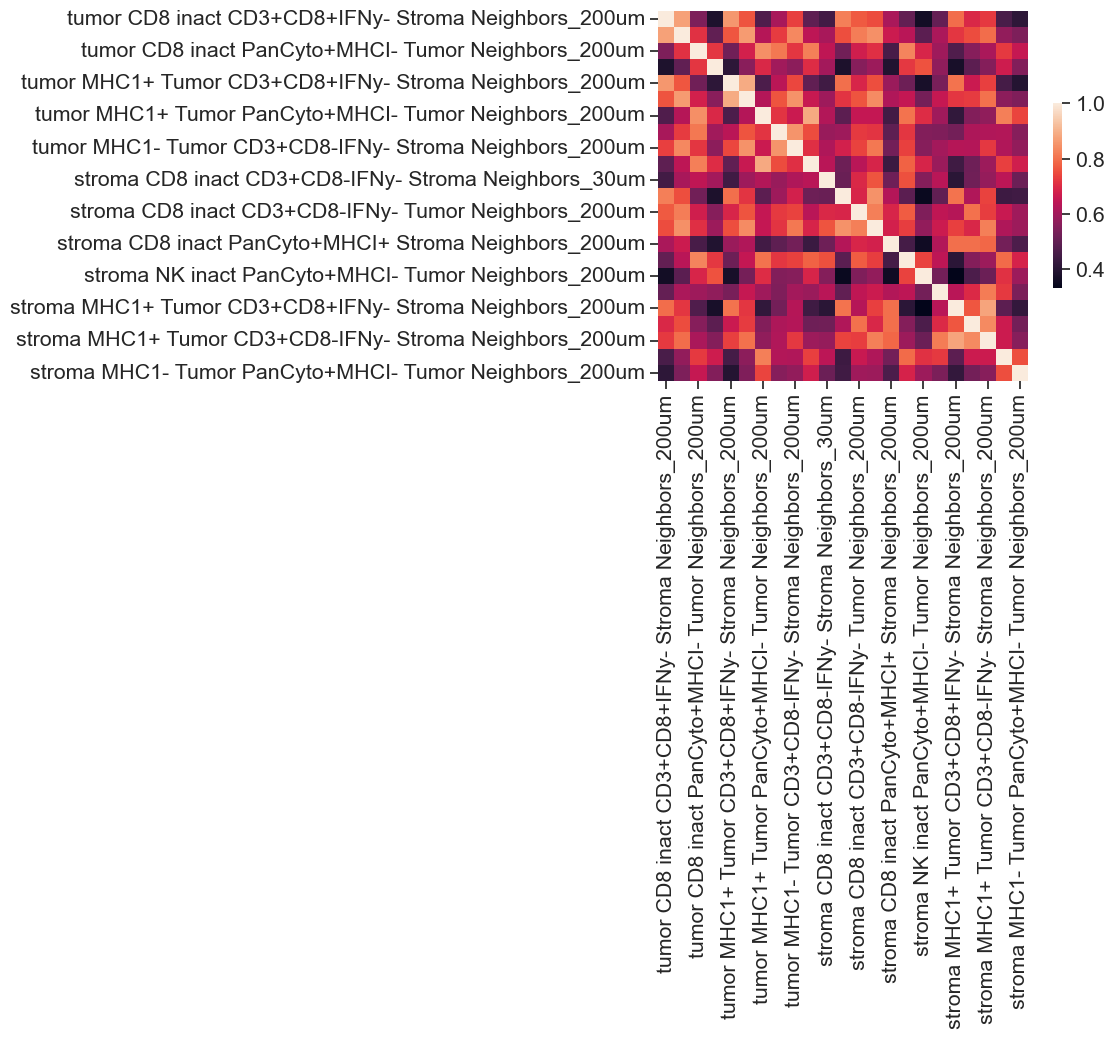

In [83]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_filt,
            square=True, cbar_kws={"shrink": .5})
#plt.title('HLA subunit Expression Correlations') 
plt.xlabel(None)
plt.ylabel(None)
#plt.savefig('../results/plsr_filtered_correlations.png')
plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7d_network_heatmap.png', bbox_inches = 'tight')


/home/gh8sj/.local/lib/python3.11/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


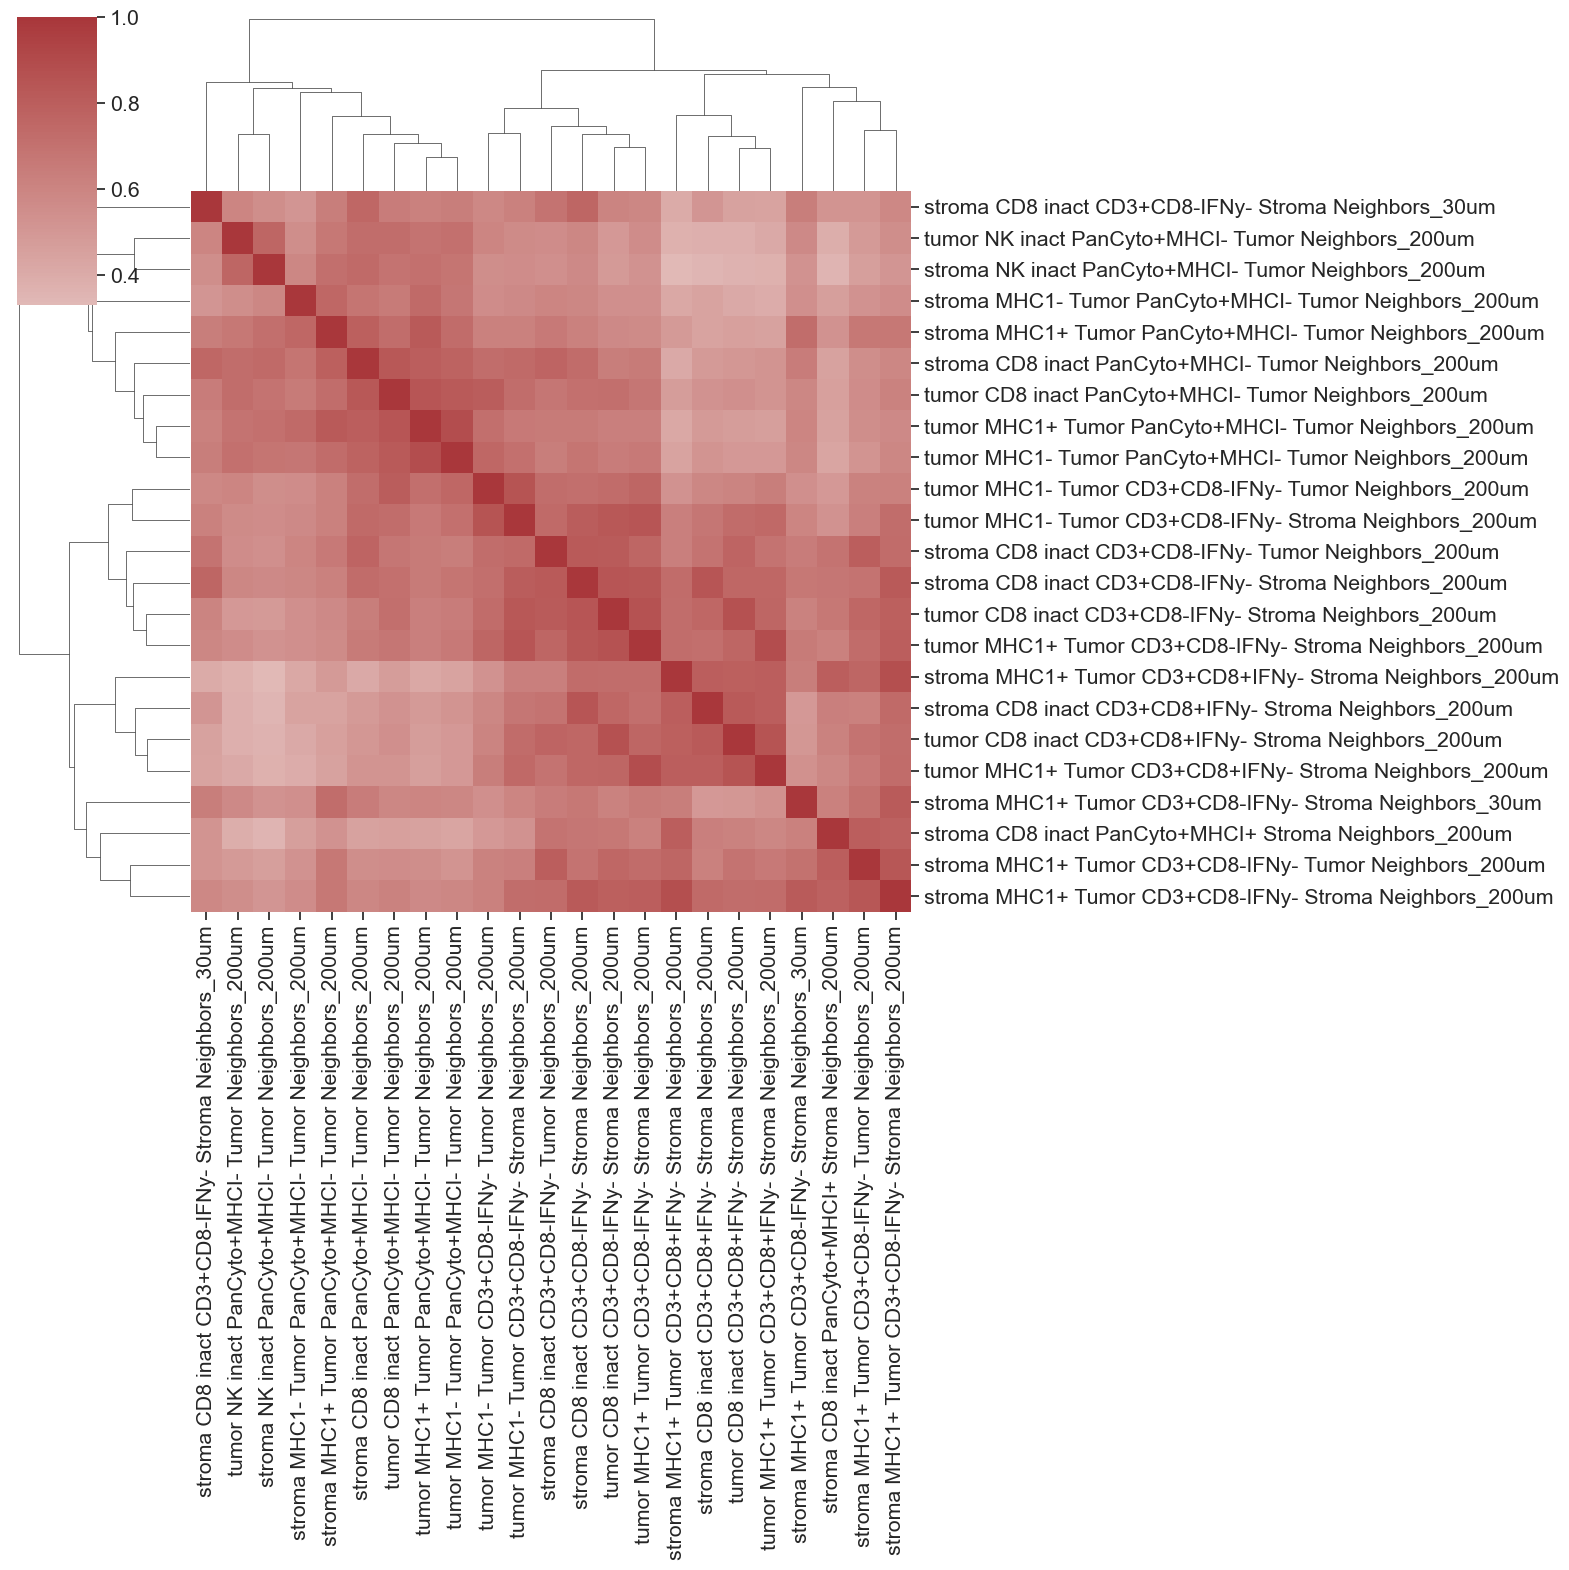

In [84]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.clustermap(corr_filt,
            square=True, cbar_kws={"shrink": .5},figsize=(16,16), cmap = 'vlag', center = 0)
#plt.title('HLA subunit Expression Correlations') 
plt.xlabel(None)
plt.ylabel(None)
#plt.savefig('../results/plsr_filtered_correlations.png')
plt.savefig('/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7d_clustered_network_heatmap.png', bbox_inches = 'tight')


# makes this into a network using nx

In [85]:
# Build your graph
G=nx.from_pandas_edgelist(plsr_links_filtered, 'var1', 'var2')
color = []
for v, data in G.nodes(data=True):
    if v in color_dict.keys():
        color.append(color_dict[v])
    else:
        color.append('orange')
color;

node_sizes = []
for v, data in G.nodes(data=True):
    if v in color_dict.keys():
        node_sizes.append(50)
    else:
        node_sizes.append(2.5)
        
pos = nx.spring_layout(G, seed = 42)

In [86]:
def draw(G, pos, measures, measure_name, save = False, file=''):
    
    # for dynamic coloring related to measures of connectivity 
    #nodes = nx.draw_networkx_nodes(G, pos, node_size=5, cmap=plt.cm.plasma, 
    #                               node_color=list(measures.values()),
    #                               nodelist=measures.keys())
    
    # for specific coloring I set
    color = []
    for v, data in G.nodes(data=True):
        if v in color_dict.keys():
            color.append(color_dict[v])
        else:
            color.append('black')
    color;
    
    node_sizes = []
    for v, data in G.nodes(data=True):
        if v in color_dict.keys():
            node_sizes.append(50)
        else:
            node_sizes.append(2.5)
            
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                                   node_color=list(color),
                                   nodelist=measures.keys())
    
    # 
    # log-scale colormap for better visualization and contrast
    # nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    
    # turn labels on?
    node_labels = {}
    for v, data in G.nodes(data=True):
        if v in color_dict.keys():
            node_labels[v] = v
        else:
            node_labels[v] = v
#            node_labels[v] = ''

    labels = nx.draw_networkx_labels(G, pos, labels = node_labels, font_color='k', font_size = 9)
    
    edges = nx.draw_networkx_edges(G, pos, width =0.15)


    plt.title(measure_name)
    #plt.colorbar()
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(22, 8)
    if save == True:
        plt.savefig(file, bbox_inches = 'tight')
    else:
        return
    plt.show()
    

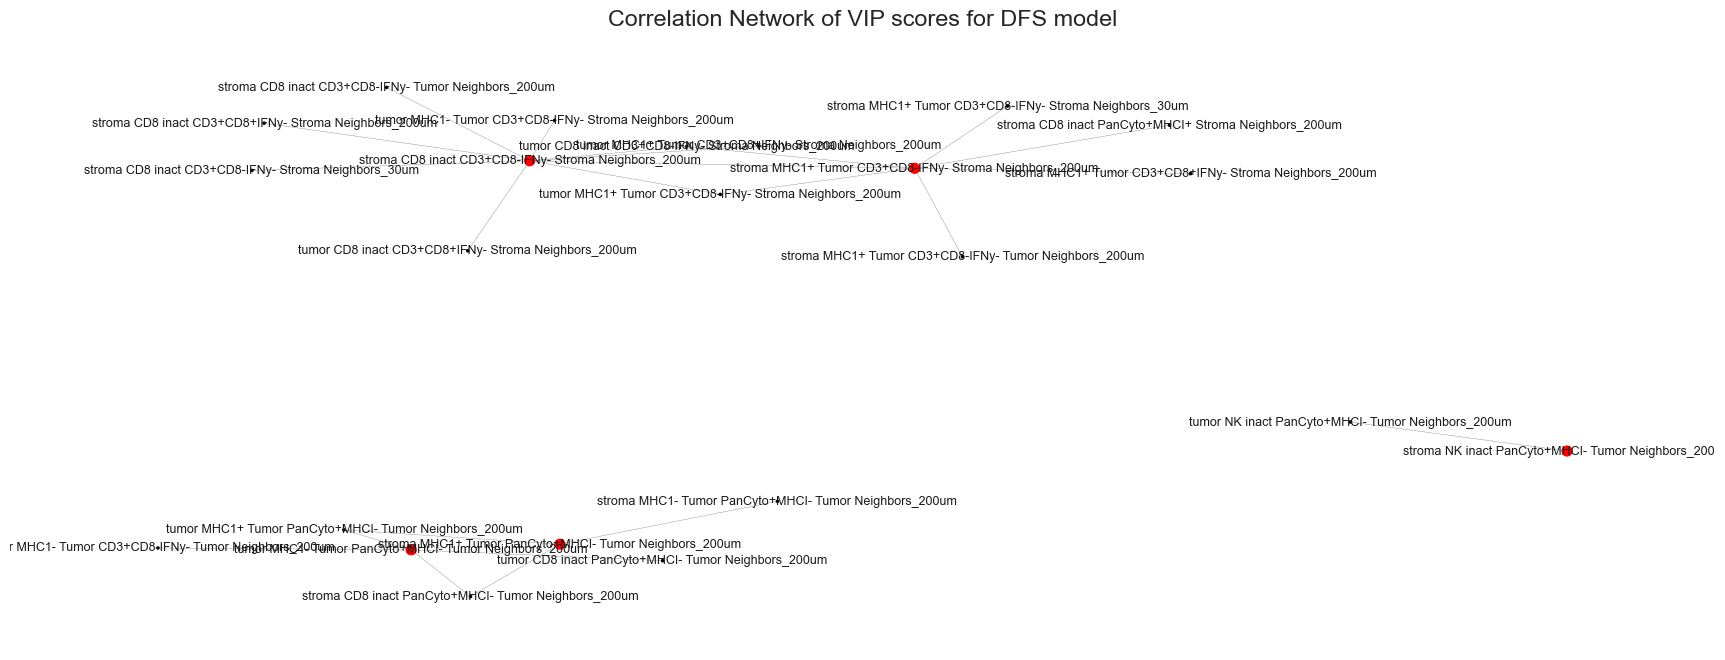

In [88]:
pos = nx.spring_layout(G, k=1.8, iterations=250)
draw(G, pos, nx.degree_centrality(G), 'Correlation Network of VIP scores for DFS model', save = True, file = '/home/gh8sj/projects/gabe_kate_method/figures/nsclc/final_figures/fig_7d_network.pdf',)#,format='pdf', bbox_inches = 'tight')

